# NSSP - Miniproject1

# Part 1: Data Preprocessing

In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
sys.path.append('../Labs')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [2]:
################
# Start FSLeyes within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

Gtk-Message: 19:22:36.631: Failed to load module "canberra-gtk-module"

(ipykernel_launcher.py:25509): Gtk-CRITICAL **: 19:22:37.122: gtk_window_resize: assertion 'height > 0' failed


In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

## 0. Download Datasets

In [4]:
dataset_id = 'ds000171'
subject = 'control01' 

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)

###################
# Openneuro download.
###################
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", op.join(subject_dir, '*'),# We are asking to get all files within the subject_dir/anat folder by using the wildcard *
               ], check=True)

###################
# Create folders relevant for preprocessing.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, subject_dir))
mkdir_no_exist(op.join(preproc_root, subject_dir, 'anat'))
mkdir_no_exist(op.join(preproc_root, subject_dir, 'func'))
mkdir_no_exist(op.join(preproc_root, subject_dir, 'fmap'))


üëã Hello! This is openneuro-py 2024.2.0. Great to see you! ü§ó

   üëâ Please report problems ü§Ø and bugs ü™≤ at
      https://github.com/hoechenberger/openneuro-py/issues

üåç Preparing to download ds000171 ‚Ä¶


üìÅ Traversing directories for ds000171 : 436 entities [00:39, 11.04 entities/s]


üì• Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   3%|‚ñé         | 288k/8.77M [00:00<00:07, 1.17MB/s]
sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]


sub-control01_task-music_run-2_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]


                                                                                    


sub-control01_T1w.nii.gz:   6%|‚ñã         | 577k/8.77M [00:00<00:05, 1.44MB/s]0<?, ?B/s]
sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 83.6k/33.8M [00:00<01:16, 465kB/s]

sub-control01_T1w.nii.gz:  10%|‚ñà         | 935k/8.77M [00:00<00:03, 2.10MB/s]00<01:22, 428kB/s]


sub-control01_task-music_run-3_bold.nii.gz:   0%|          | 49.6k/33.9M [00:00<02:06, 280kB/s]
sub-control01_task-music_run-1_bold.nii.gz:   1%|          | 323k/33.8M [00:00<00:26, 1.33MB/s]



sub-control01_task-music_run-3_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]


‚úÖ Finished downloading ds000171.
 
üß† Please enjoy your brains.
 


In [5]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


## 1. Anatomical preprocessing

In [6]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root,subject_dir,'anat', 'sub-control01_T1w.nii.gz'))


(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:36.839: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:36: Debug: ClientToScreen cannot work when toplevel window is not shown
19:23:36: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:36.842: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:36: Debug: ClientToScreen cannot work when toplevel window is not shown
19:23:36: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:36.843: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:36: Debug: ClientToScreen cannot work when toplevel window is not shown
19:23:36: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:36.844: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:36: Debug: ClientToScreen cannot work when topleve

### 1.1 Remove the skull

In [7]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')

In [8]:
# improve the fit
get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, subject_dir, 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

Done with BET.



(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:49.518: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:49: Debug: ClientToScreen cannot work when toplevel window is not shown
19:23:49: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:49.520: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:49: Debug: ClientToScreen cannot work when toplevel window is not shown
19:23:49: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:49.521: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:49: Debug: ClientToScreen cannot work when toplevel window is not shown
19:23:49: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:49.523: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:49: Debug: ClientToScreen cannot work when topleve

#### * After improving the fit, do mannual corrections if needed. Then apply the mask to T1 through fslmaths.

In [9]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    """Apply resulted mask to T1"""
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, subject_dir, 'anat', 'sub-control01_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w_mask.nii.gz') # The mask to use

apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [10]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)


(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:51.864: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:51: Debug: ClientToScreen cannot work when toplevel window is not shown
19:23:51: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:51.866: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:51: Debug: ClientToScreen cannot work when toplevel window is not shown
19:23:51: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:51.867: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:51: Debug: ClientToScreen cannot work when toplevel window is not shown
19:23:51: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:23:51.868: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:23:51: Debug: ClientToScreen cannot work when topleve

### 1.2 Tissue segmentation

In [11]:
bet_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')

fast_target = bet_path 
[os.remove(f) for f in glob.glob(op.join(preproc_root, 'sub-control01', 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

{}

In [12]:
#check the segmentation result with RGB
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, 'sub-control01', 'anat','*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'


(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:26:43.669: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:26:43: Debug: ClientToScreen cannot work when toplevel window is not shown
19:26:43: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:26:43.671: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:26:43: Debug: ClientToScreen cannot work when toplevel window is not shown
19:26:43: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:26:43.673: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:26:43: Debug: ClientToScreen cannot work when toplevel window is not shown
19:26:43: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:26:43.674: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:26:43: Debug: ClientToScreen cannot work when topleve

### 1.3 Coregistration
Aim: to make participant's brain match with a reference brain so that comparison across participants become feasible.

Here we use linear normalization by flirt().

In [13]:
from fsl.wrappers import flirt

subject_id = 'control01'
subject_anatomical = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w')
mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = subject_anatomical 
reference = mni_template 
result = op.join(preproc_root, subject_dir, 'anat', 'sub-{}_T1w_mni'.format(subject_id))
flirt(target, reference, out=result)


Final result: 
0.003348 0.005721 -1.116064 204.794610 
-0.933350 0.500887 0.005750 178.784833 
0.501418 1.048657 -0.003251 -149.700516 
0.000000 0.000000 0.000000 1.000000 



{}

In [14]:
#Visualize the result
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference) 
fsleyesDisplay.load(result)


(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:27:51.966: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:27:51: Debug: ClientToScreen cannot work when toplevel window is not shown
19:27:51: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:27:51.969: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:27:51: Debug: ClientToScreen cannot work when toplevel window is not shown
19:27:51: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:27:51.970: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:27:51: Debug: ClientToScreen cannot work when toplevel window is not shown
19:27:51: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:27:51.971: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:27:51: Debug: ClientToScreen cannot work when topleve

## 2. Standardize T2 files

#### Before standardization, extract brain tissue.

In [15]:
def get_skull_stripped_func(bids_root, preproc_root, subject_id, run = 1, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T2w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = 'sub-{}'.format(subject_id)
    func_path = op.join(bids_root, subject, 'func', f'sub-{subject_id}_task-music_run-{run}_bold.nii.gz')
    betted_brain_path = op.join(preproc_root, subject, 'func', f'sub-{subject_id}_task-music_run-{run}_bold.nii.gz')
    os.system('bet {} {} -m {}'.format(func_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")


In [16]:
for i in range(3):
    run = i+1
    get_skull_stripped_func(bids_root, preproc_root,"control01", run=run, robust=True)

    func_path = op.join(bids_root, subject_dir, 'func', f'sub-control01_task-music_run-{run}_bold.nii.gz') # The original brain
    betted_brain_path = op.join(preproc_root, subject_dir, 'func', f'sub-control01_task-music_run-{run}_bold.nii.gz') # The brain without skull is in the derivatives folder
    resulting_mask_path = op.join(preproc_root, 'sub-control01', 'func', f'sub-control01_task-music_run-{run}_bold_mask.nii.gz')
    
    apply_fsl_math_approach(func_path, resulting_mask_path, betted_brain_path)

Done with BET.


Done with BET.


Done with BET.


#### Verify possible problematic volumes

In [17]:
subject

'control01'

Text(0.5, 1.0, 'Mean BOLD Signal After Brain Extraction')

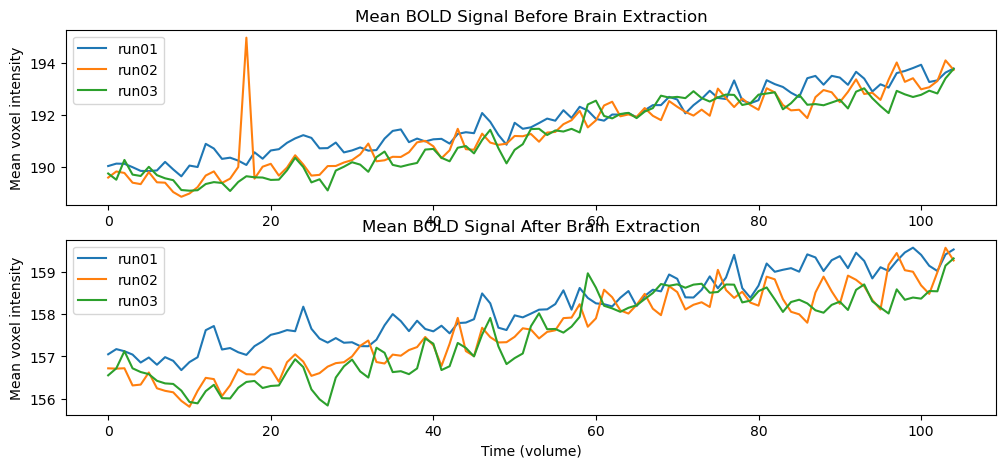

In [18]:
# Visualize mean voxel intensity of bold files
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
for run_idx in range(1, 3+1):
    plt.plot(nib.load(op.join(bids_root, f'sub-{subject}','func', f'sub-control01_task-music_run-{run_idx}_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)), label=f'run0{run_idx}')
plt.legend()
plt.ylabel('Mean voxel intensity')
plt.title('Mean BOLD Signal Before Brain Extraction')

plt.subplot(2, 1, 2)
for run_idx in range(1, 3+1):
    plt.plot(nib.load(op.join(preproc_root, f'sub-{subject}','func', f'sub-control01_task-music_run-{run_idx}_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)), label=f'run0{run_idx}')
plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')
plt.title('Mean BOLD Signal After Brain Extraction')

Since we did not find any obvious problematic volumes according to the above figure, we skipped removing the problematic volumes.

#### Standardize and concact all runs of interest.

In [19]:
import nibabel as nib
import numpy as np

def standardize_session(file_path):
    # Load MRI data using nibabel
    img = nib.load(file_path)
    data = img.get_fdata()

    # Compute mean and standard deviation of the session
    mean = np.mean(data)
    std = np.std(data) / np.sqrt(data.shape[0] * data.shape[1] * data.shape[2])

    # Standardize (z-score)
    standardized_data = (data - mean) / std

    # Save the standardized data
    standardized_img = nib.Nifti1Image(standardized_data, img.affine, img.header)
    output_path = file_path.replace('.nii.gz', '_standardized.nii.gz')
    nib.save(standardized_img, output_path)

    print(f'Saved standardized image to {output_path}')
    return output_path

In [20]:
original_file_dir = op.join(preproc_root,subject_dir,'func')

standardized_files = []

for file in os.listdir(original_file_dir):
    if '_task-music_run' in file and file.endswith('_bold.nii.gz'):
        file_path = op.join(original_file_dir,file)
        standardized_file = standardize_session(file_path)
        img = nib.load(standardized_file)
        data = img.get_fdata()
        standardized_files.append(data)

concatenated_data = np.concatenate(standardized_files, axis=3)

# Save the concatenated data
mkdir_no_exist(op.join(preproc_root, subject_dir, 'func'))
mkdir_no_exist(op.join(preproc_root, subject_dir, 'fmap'))
concatenated_img = nib.Nifti1Image(concatenated_data, img.affine, img.header)
all_runs_concat_path = op.join(preproc_root, subject_dir, 'func','sub-control01_task-music_run_concatenated.nii.gz')
nib.save(concatenated_img, all_runs_concat_path)

print(f'Concatenated all sessions and saved to {all_runs_concat_path}')

Saved standardized image to /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-3_bold_standardized.nii.gz
Saved standardized image to /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_standardized.nii.gz
Saved standardized image to /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-2_bold_standardized.nii.gz
Concatenated all sessions and saved to /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_concatenated.nii.gz


In [21]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mni.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_task-music_run-1_bold.nii.gz
|--------------- sub-control01_task-music_run-1_bold_mask.nii.gz
|--------------- sub-control01_task-music_run-1_bold_standardized.nii.gz
|--------------- sub-control01_task-music_run-2_bold.nii.gz
|--------------- sub-control01_task-music_run-2_bold_mask.nii.gz
|-

Text(0, 0.5, 'Mean voxel intensity after standardization')

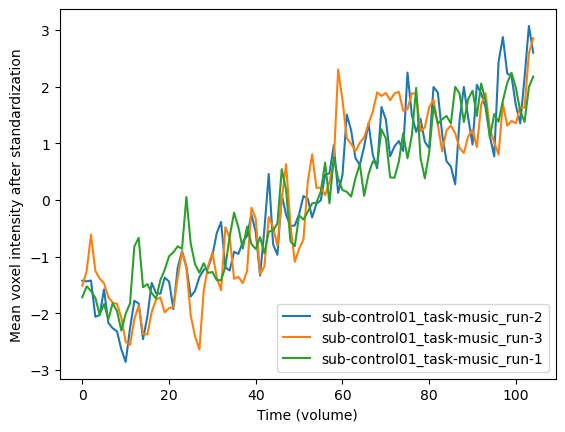

In [22]:
# Visualize mean voxel intensity after standardization
import matplotlib.pyplot as plt

for file in os.listdir(op.join(preproc_root, 'sub-control01','func')):
    if '_task-music_run' in file and file.endswith('_bold_standardized.nii.gz'):
        filename = op.join(preproc_root, 'sub-control01','func',file)

        mean_intensity = nib.load(filename).get_fdata().mean(axis=(0,1,2))
        
        plt.plot(mean_intensity,label = file.replace('_bold_standardized.nii.gz',''))

plt.legend()
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity after standardization')

## 3. Motion correction

In [23]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01','func', 'sub-control01_task-music_run_concatenated.nii.gz'))


(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:28:29.934: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:28:29: Debug: ClientToScreen cannot work when toplevel window is not shown
19:28:29: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:28:29.937: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:28:29: Debug: ClientToScreen cannot work when toplevel window is not shown
19:28:29: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:28:29.940: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:28:29: Debug: ClientToScreen cannot work when toplevel window is not shown
19:28:29: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:28:29.944: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:28:29: Debug: ClientToScreen cannot work when topleve

In [24]:
from fsl.wrappers import mcflirt

path_original_data = op.join(preproc_root, subject_dir,'func', 'sub-control01_task-music_run_concatenated.nii.gz')
path_moco_data = os.path.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_concatenated_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288]

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [25]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)


(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:29:34.330: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:29:34: Debug: ClientToScreen cannot work when toplevel window is not shown
19:29:34: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:29:34.332: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:29:34: Debug: ClientToScreen cannot work when toplevel window is not shown
19:29:34: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:29:34.334: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:29:34: Debug: ClientToScreen cannot work when toplevel window is not shown
19:29:34: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:29:34.335: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:29:34: Debug: ClientToScreen cannot work when topleve

In [26]:
# check the the resulting correction parameters

def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_moco.par'))
mot_params

Rotation x  Rotation y  Rotation z  Translation x  Translation y  \
0      0.011061   -0.001602   -0.002038      -0.038756       0.443992   
1      0.011443   -0.001563   -0.002133      -0.037264       0.469700   
2      0.011576   -0.001759   -0.002046      -0.036892       0.469752   
3      0.011690   -0.001762   -0.002027      -0.024550       0.487628   
4      0.011322   -0.001804   -0.001848      -0.016867       0.491237   
..          ...         ...         ...            ...            ...   
310    0.006752   -0.001863   -0.000995       0.042297       0.541009   
311    0.006570   -0.002093   -0.001082       0.045137       0.540907   
312    0.006247   -0.002206   -0.000838       0.037853       0.605497   
313    0.006357   -0.002050   -0.000914       0.028180       0.582437   
314    0.006315   -0.001653   -0.000915       0.028009       0.598753   

     Translation z  
0         0.280519  
1         0.298154  
2         0.300657  
3         0.329739  
4         0.344703  
..             ...  
310       0.477621  
311       0.493278  
312       0.488915  
313       0.488011  
314       0.488034  

[315 rows x 6 columns]

In [27]:
# Check the displacement on a 50mm radius sphere

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [28]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

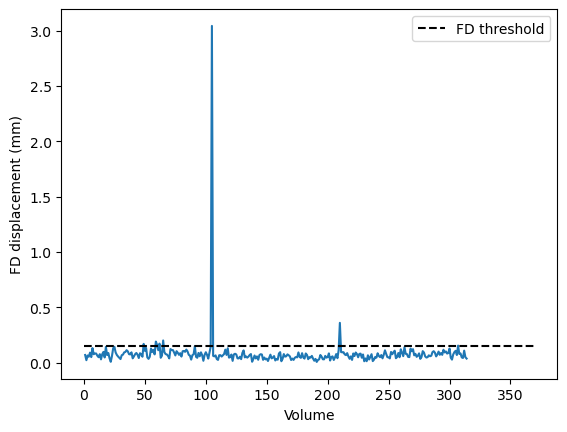

In [29]:
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [30]:
np.where(fd > threshold)[0] + 1

array([ 49,  59,  60,  62,  65,  91, 105, 210, 307])

## 4.Coregistration of functional to anatomical

In [31]:
from fsl.wrappers import epi_reg

epi_target = op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_moco')
whole_t1 = op.join(bids_root, subject_dir, 'anat', 'sub-control01_T1w')
skull_stripped_t1 = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w')
white_matter_segmentation = op.join(preproc_root, subject_dir, 'anat', 'sub-control01_T1w_fast_pve_2.nii.gz') # Use the white matter segmentation

registered_func = op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_bbr')
ref_vol_name =  op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_moco_vol_middle')

use_single_vol = True

"""
if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    middle_index= nib.load(op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated.nii.gz')).shape[3]//2
    fslroi(epi_target, ref_vol_name, str(middle_index), str(1))
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(registered_func),
               '--wmseg={}'.format(white_matter_segmentation)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(epi_target), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(nc),
               '--wmseg={}'.format(white_matter_segmentation)])
"""
if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    middle_index= nib.load(op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated.nii.gz')).shape[3]//2
    fslroi(epi_target, ref_vol_name, str(middle_index), str(1))
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(registered_func)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(epi_target), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(registered_func)])



Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.305275 0.999648 -0.024514 -0.010127 0.000000 0.024454 0.999683 -0.006026 0.000000 0.010272 0.005776 0.999931 0.000000 -4.129603 5.929639 2.357370 1.000000 


In [32]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(skull_stripped_t1)
fsleyesDisplay.load(registered_func)


(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:33:37.598: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:33:37: Debug: ClientToScreen cannot work when toplevel window is not shown
19:33:37: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:33:37.601: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:33:37: Debug: ClientToScreen cannot work when toplevel window is not shown
19:33:37: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:33:37.602: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:33:37: Debug: ClientToScreen cannot work when toplevel window is not shown
19:33:37: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:25509): Gdk-WARNING **: 19:33:37.603: gdkdrawable-x11.c:952 drawable is not a pixmap or window
19:33:37: Debug: ClientToScreen cannot work when topleve

## 5. Smoothing

In [33]:
# Load the image & get the voxel size
img = nib.load(op.join(preproc_root, 'sub-control01','func', 'sub-control01_task-music_run-1_bold.nii.gz'))
voxel_size = img.header.get_zooms()[:3] 
voxel_size

(2.9, 2.9, 3.0)

In [34]:
# Choose 6mm as FWHM
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(registered_func, 6/2.3548, registered_func)
subprocess.run(['fslmaths',registered_func, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(registered_func)])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_concatenated_bbr', '-s', '2.547987090198743', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run_concatenated_bbr_smoothed-6mm'], returncode=0)

In [35]:
fsleyesDisplay.load(registered_func + '_smoothed-6mm')

# Part 2: GLM Analysis

## 1. Add experimental events

In [36]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
t_r = 3  # Repetition time for this data is 3s
t_e = 0.025  # Echo time for this data is 25ms

# Concatenate all events across 3 runs
events_all_runs = pd.DataFrame()
for run_idx in range(1, 3+1):
    fmri_cur_run = nib.load(op.join(preproc_root, f'sub-{subject}', 'func', f'sub-control01_task-music_run-{run_idx}_bold.nii.gz'))
    if run_idx == 1:
        events = pd.read_table(op.join(bids_root, f'sub-{subject}', 'func', f'sub-control01_task-music_run-{run_idx}_events.tsv'))
    else:
        last_time = events['onset'].iloc[-1] + events['duration'].iloc[-1]
        events = pd.read_table(op.join(bids_root, f'sub-{subject}', 'func', f'sub-control01_task-music_run-{run_idx}_events.tsv'))
        events['onset'] = events['onset'] + last_time
    events_all_runs = pd.concat((events_all_runs, events), axis=0).reset_index(drop=True)
fmri_all_runs = nib.load(op.join(preproc_root, subject_dir, 'func','sub-control01_task-music_run_concatenated.nii.gz'))

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(
    t_r=t_r,
    noise_model='ar1',        
    standardize=True,
    hrf_model='spm',
    drift_model=None,
    high_pass=.01
)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_all_runs, events_all_runs)

**Generate Design Matrix: Note, the design matrix is not binary, because the task design is convolved with HRF.**

## 2. Add low frequency components to account for drift

In [37]:
from nilearn.glm.first_level.design_matrix import _make_drift
frame_times = np.asarray(range(fmri_all_runs.get_fdata().shape[3])) * t_r
column_values, column_names = _make_drift(drift_model='polynomial', frame_times=frame_times, order=6, high_pass=None)

design_mat = fmri_glm.design_matrices_[0]
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col

## 3. Add motion parameters

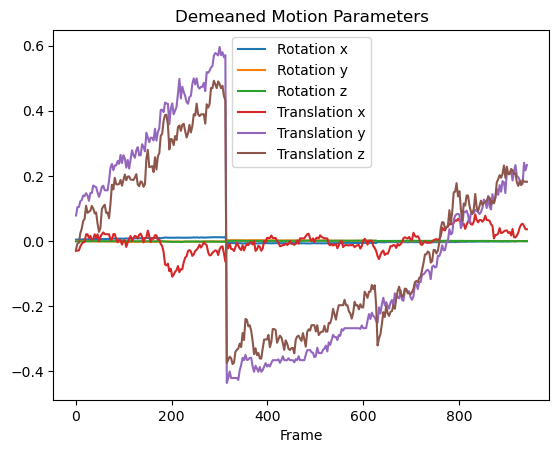

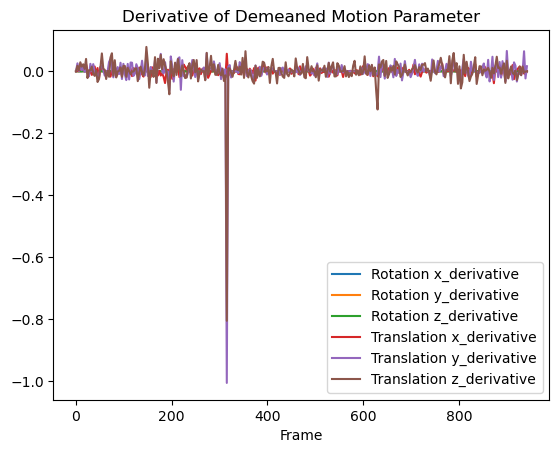

In [38]:
mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, subject_dir, 'func', 'sub-control01_task-music_run_concatenated_moco.par'))
mot_params = mot_params - mot_params.mean()
mot_params.index = mot_params.index * 3
mot_params.plot(title='Demeaned Motion Parameters', xlabel='Frame')

mot_params_deriv = mot_params.diff().fillna(0)
mot_params_deriv.columns = [f"{col}_derivative" for col in mot_params.columns]
mot_params_deriv.plot(title='Derivative of Demeaned Motion Parameter', xlabel='Frame')

fmri_glm.design_matrices_[0] = pd.concat((fmri_glm.design_matrices_[0], mot_params, mot_params_deriv), axis=1)

In [39]:
# Account for motion outliers
outlier_frames = [60, 95, 97, 105, 164, 170, 210]
for i in range(7):
    reg = np.zeros((315,)) * 0.0
    reg[outlier_frames[i]] = 1.0
    fmri_glm.design_matrices_[0]['motion outlier#' + str(i+1)] = reg

## 4. Visualize GLM Design Matrix

In [40]:
fmri_glm.design_matrices_[0] = fmri_glm.design_matrices_[0].drop(['response', 'tones'], axis=1)

In [41]:
fmri_glm = fmri_glm.fit(fmri_all_runs, design_matrices=fmri_glm.design_matrices_[0])

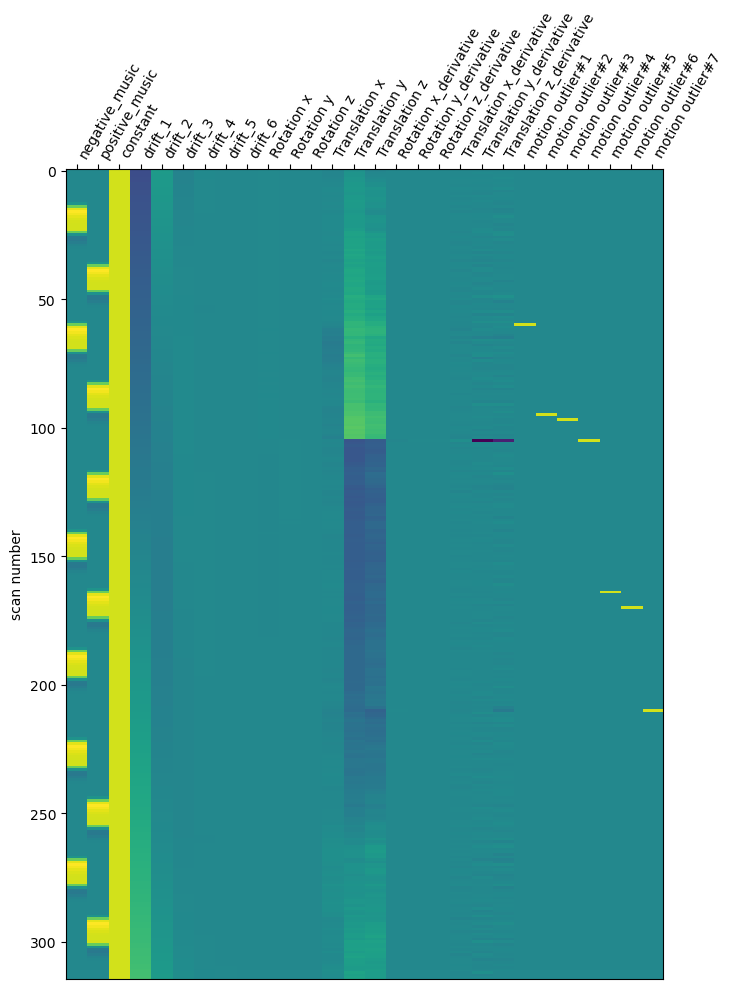

In [42]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0], rescale=False)
plt.show()

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'Pearson correlation (absolute value) between regressors')

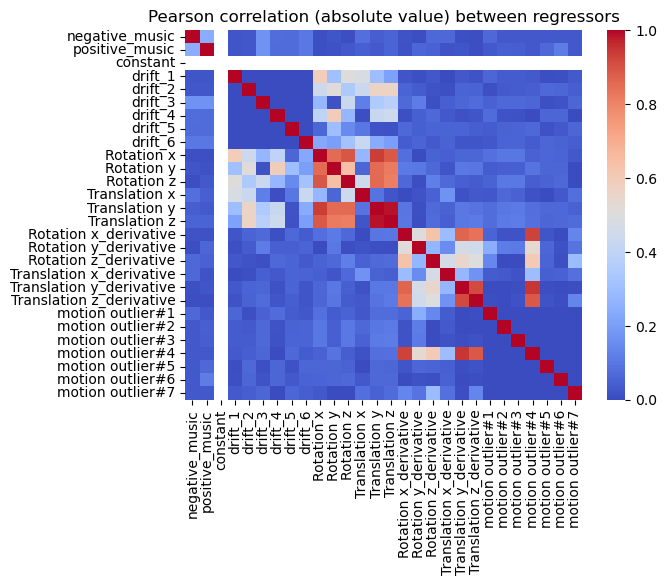

In [43]:
import seaborn as sns
sns.heatmap(
    np.abs(np.corrcoef(fmri_glm.design_matrices_[0].T)), 
    xticklabels=fmri_glm.design_matrices_[0].columns, 
    yticklabels=fmri_glm.design_matrices_[0].columns,
    cmap='coolwarm'
)
plt.title('Pearson correlation (absolute value) between regressors')

# 5. Apply GLM analysis and get contrast between positive / negative

<Axes: label='conditions'>

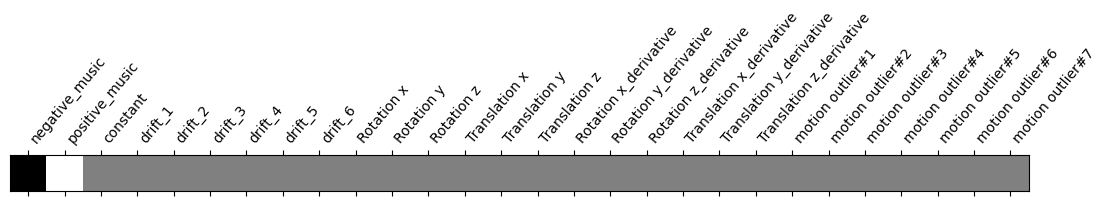

In [44]:
# Create contrast
import numpy as np
conditions = {
    'positive': np.array([0, 1, 0] + [0] * 25), # Specify the np array, e.g. np.array([2, -1, 0]) to extract active
    'negative': np.array([1, 0, 0] + [0] * 25) # Specify the np array, e.g. np.array([2, -1, 0]) to extract rest
}

pos_minus_neg = conditions['positive'] - conditions['negative']
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(pos_minus_neg, design_matrix=fmri_glm.design_matrices_[0])  ####TODO ADD COLOR SCALE
# pos_minus_neg = pos_minus_neg[:3]

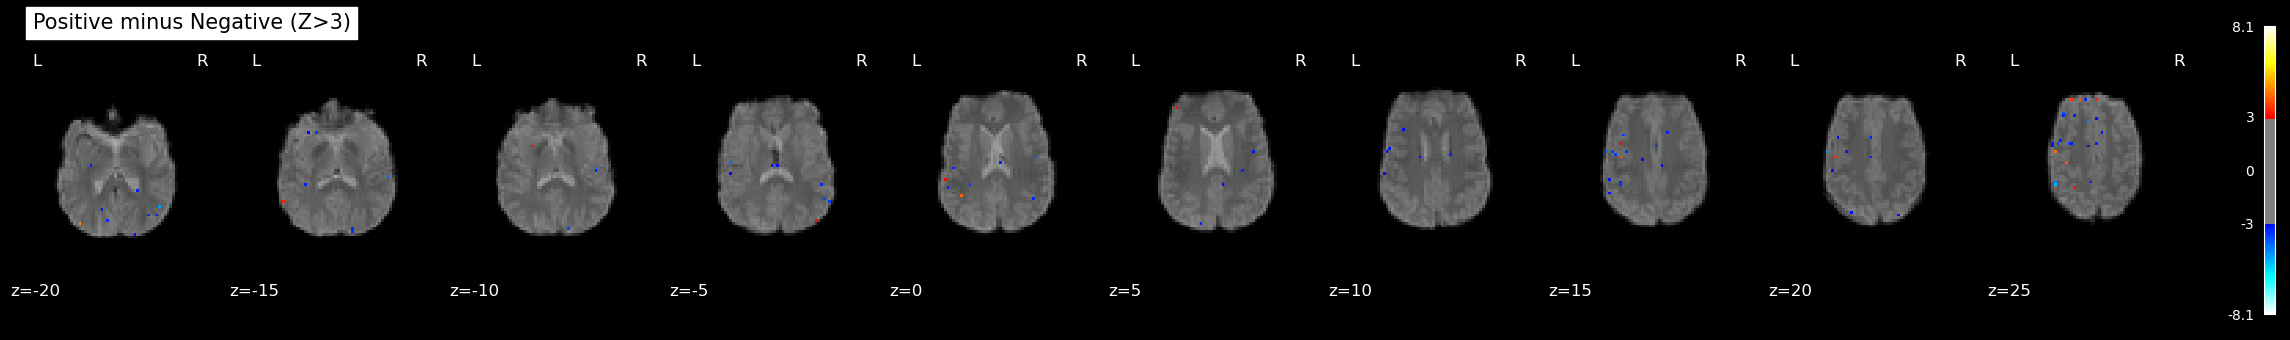

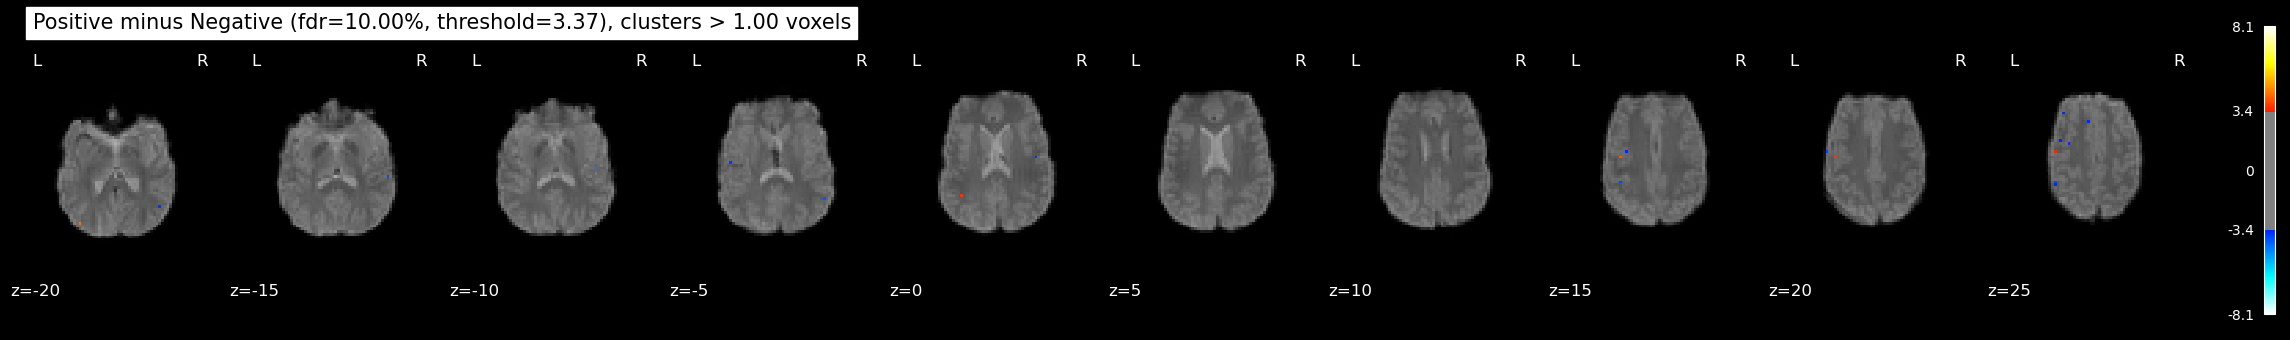

In [45]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.glm import threshold_stats_img
import nibabel as nib

z_map = fmri_glm.compute_contrast(pos_minus_neg, output_type='z_score')
nib.save(z_map, op.join(preproc_root, f'sub-{subject}', 'func', f'sub-{subject}_task-music_run_concatenated_z_map_uncorrected.nii.gz'))

mean_img_ = mean_img(fmri_all_runs),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3,
              display_mode='z', cut_coords=range(-20, 30, 5), black_bg=True,
              title='Positive minus Negative (Z>3)')


fdr_rate = 0.10 # Fill me with the fdr rate to use!
cluster_size = 1 # Fill me with the number of voxels for a cluster to be kept

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=range(-20, 30, 5), black_bg=True,
              title='Positive minus Negative (fdr=%.2f%%, threshold=%.2f), clusters > %.2f voxels' % (fdr_rate * 100, threshold, cluster_size))
plt.show()

## 6. Check Different Beta Maps

---- Current condition: positive
---- Current condition: negative


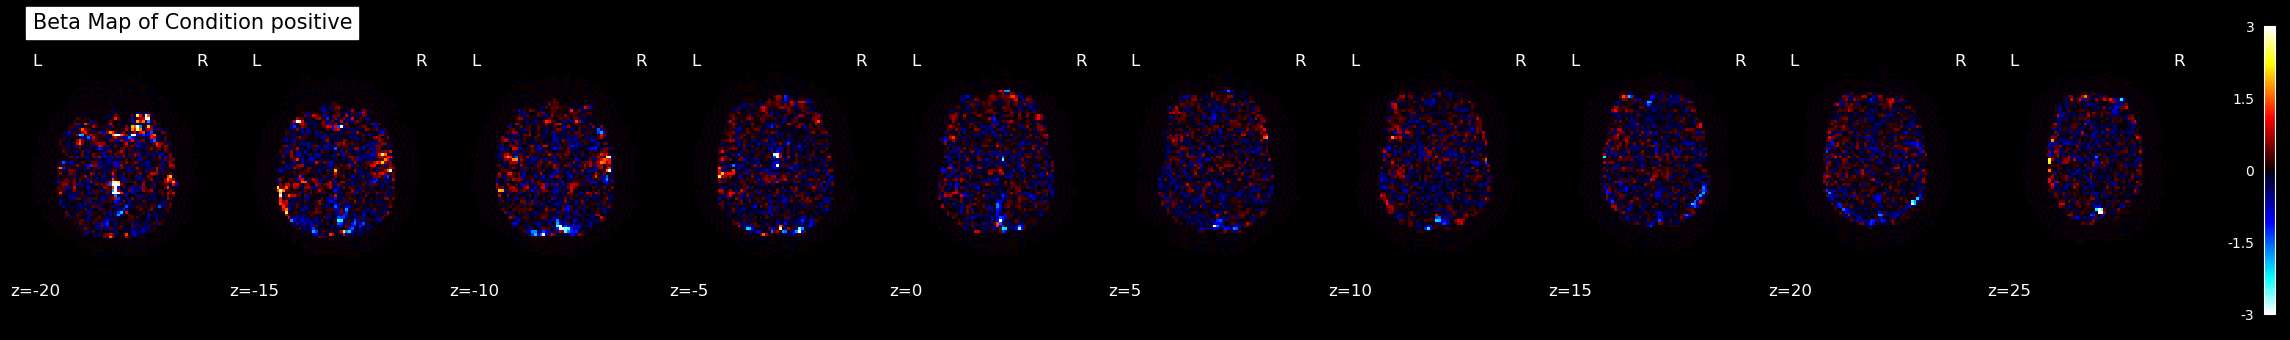

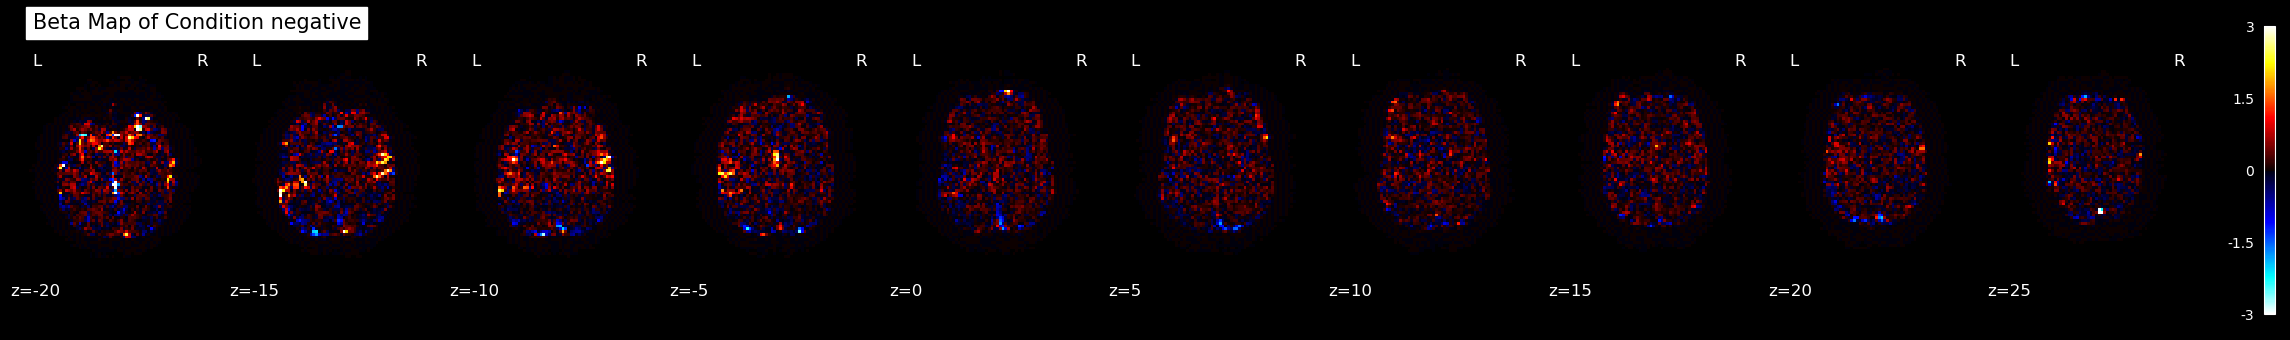

In [46]:
for condition in conditions:
    print(f'---- Current condition: {condition}')
    beta_map = fmri_glm.compute_contrast(conditions[condition], output_type='effect_size')
    mean_img_ = mean_img(fmri_all_runs),
    plot_stat_map(beta_map, bg_img=mean_img_[0], display_mode='z', cut_coords=range(-20, 30, 5), black_bg=True,
                  title=f'Beta Map of Condition {condition}', vmin=-3, vmax=3)
    

# K Means

In [ ]:
img = nib.load(op.join(preproc_root, 'sub-control01','func', 'sub-control01_task-music_run-1_bold.nii.gz'))
affine = img.affine
data = np.asanyarray(img.dataobj)
print(data.shape)
print(affine)

(80, 80, 50, 105)
[[-2.89823341e+00  0.00000000e+00  1.04698524e-01  1.18931046e+02]
 [-6.50556833e-02  2.22152901e+00 -1.92718816e+00 -7.74534302e+01]
 [ 7.75302127e-02  1.86408401e+00  2.29673338e+00 -1.40277512e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Preprocessing
We can think of the shape of the data as two parts - the first 3 values are the 3D shape of the individual volumes, and the last value is the number of volumes. Put the 3D shape into a variable vol_shape and the number of volumes into a variable n_vols:

In [55]:
# Make variables:
# 'vol_shape' for shape of volumes
# 'n_vols' for number of volumes
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]

When applying K-Means, we will take the timepoints as being the ‚Äúsamples‚Äù and the voxels to be the features. Note however that per volume there are many useless voxels, such as the background. We will first be removing it, and flattening volume into a vector.

In [56]:
# Note: In our case the background is encoded as 0 # TODO:check
# you can consider that the first volume's background 
# voxels are the same as all following volumes

slice_non_background = data[:,:,:,0] != 0
# Vectorize : Taking only non-zero voxels into a vector 
# (NOTE: that the order is important)
samples = data[slice_non_background]

Next up we will be removing the spatial mean across timepoints from each timepoints. Calculate the mean spatial pattern and perform the substraction operation.

In [58]:
# Calculate the mean across columns
spatial_means = np.mean(samples, axis=1)
# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = np.outer(spatial_means, np.ones(n_vols))
# Subtract the means for each row, put the result into X 
X = samples - row_means
# Verify that the spatial mean behaves as expected after substraction
assert np.abs(X.mean(axis=-1)).max() < 1e-10

AssertionError: 

In [59]:
X.shape

(56448, 105)

In [ ]:
from copy import deepcopy
# We will be using the same data for as in PCA
# Thus the background are also not taken in feature vectors
X_kmeans = deepcopy(X)

In [63]:
from sklearn.cluster import KMeans

max_nb_clusters = 10
avg_dist_samples = []
for nb_cluster in range(1, max_nb_clusters):
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init="auto").fit(X_kmeans.T)
    avg_dist_samples.append(kmeans.inertia_)

**WCSS (Within-Cluster Sum of Squares):** represents cluster inertia, which is the sum of the squares of the distances from the sample to its cluster centroid. When the number of clusters increases, WCSS usually decreases, indicating that the clustering effect is improved.

**Elbow Method:** By observing the "elbow point" in the WCSS curve (that is, the location where the WCSS decreases significantly), you can find the number of clustering results with better results.

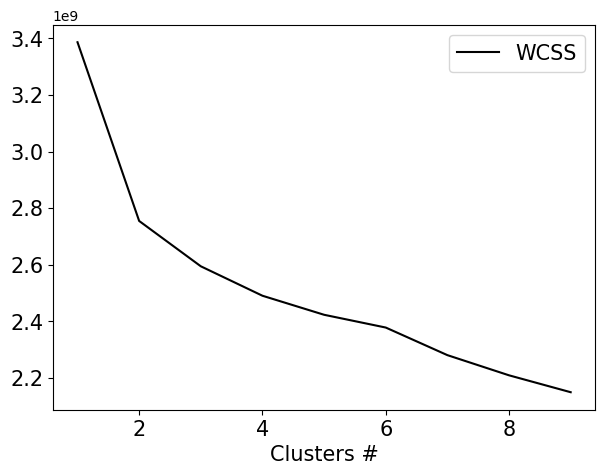

In [64]:
fig, ax = plt.subplots(1, figsize=(7,5))

ax.plot(np.arange(1, len(avg_dist_samples)+1), avg_dist_samples, label='WCSS', c='k')

ax.set_xlabel('Clusters #', size=15)
ax.legend(prop={'size':15})
ax.tick_params(axis='both', which='major', labelsize=15)

In [65]:
nb_clusters = 3 # The number of clusters you want
kmeans = KMeans(n_clusters=nb_clusters, random_state=0, n_init="auto").fit(X_kmeans.T)

kmeans_clusters = []
for cluster_idx in range(nb_clusters):
    kmeans_component = np.zeros(vol_shape)
    kmeans_component[slice_non_background] = kmeans.cluster_centers_[cluster_idx]
    kmeans_clusters.append(kmeans_component)

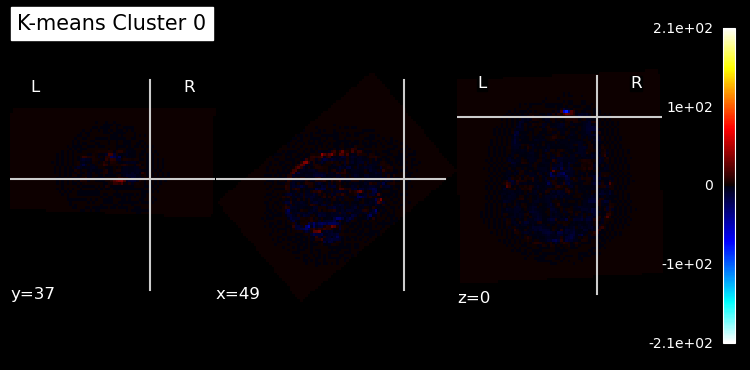

In [ ]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img)
fig, ax = plt.subplot((1, nb_clusters))
for visual_idx in range(nb_clusters):
    ax[visual_idx].plot_stat_map(nib.Nifti1Image(kmeans_clusters[visual_idx], affine), bg_img=mean_img_, threshold=0,
               cut_coords=[49,37,00], black_bg=True,
              title=f'K-means Cluster {visual_idx}')

plt.show()

# TODOÔºöËß£ÈáäÁªìÊûú